# Food Item Recognition and Calorie Estimation

In this project, we aim to develop a model that can recognize food items from images and estimate their calorie content. The dataset used is the Food-101 dataset, which contains images of various food types organized by category. The goal is to build a machine learning model that can classify food items and estimate their caloric values.

# Import Libraries

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


# Load and Explore the Dataset

In [9]:
# Define the path to the dataset
data_dir = 'Food_dataset/food-101/food-101/images'

# List all categories
categories = sorted(os.listdir(data_dir))
print(f'Total Categories: {len(categories)}')

# Display the first few categories
categories[:10]



Total Categories: 102


['.DS_Store',
 'apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding']

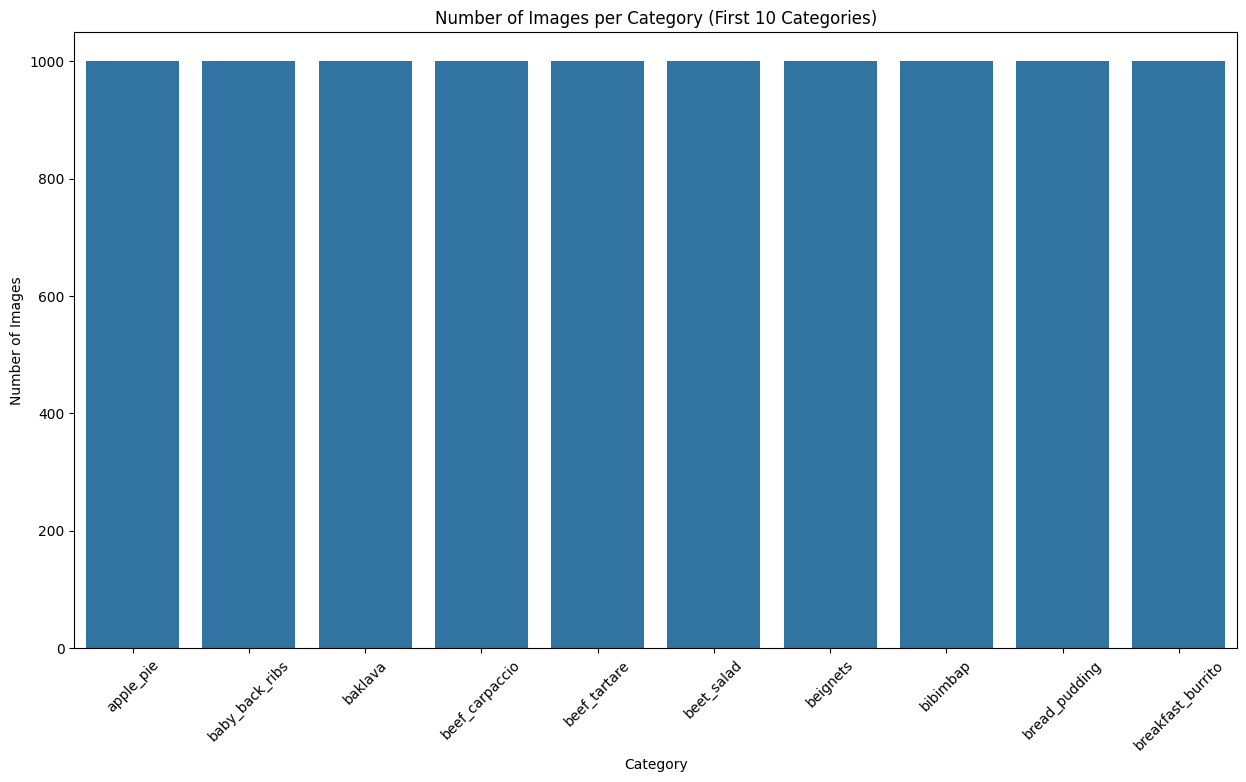

In [12]:
# Plot the distribution of images across categories
plt.figure(figsize=(15, 8))
sns.barplot(x=list(image_counts.keys())[:10], y=list(image_counts.values())[:10])
plt.title('Number of Images per Category (First 10 Categories)')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()


# Data preprocessing

In [13]:
# Image dimensions
img_width, img_height = 128, 128

# Function to load and preprocess images
def load_images(category, img_dir, img_width, img_height):
    images = []
    labels = []
    for img_name in os.listdir(img_dir):
        img_path = os.path.join(img_dir, img_name)
        img = Image.open(img_path)
        img = img.resize((img_width, img_height))
        img = np.array(img) / 255.0
        images.append(img)
        labels.append(categories.index(category))
    return np.array(images), np.array(labels)

# Load a subset of the dataset
subset_categories = categories[:5]  # Use first 5 categories for this example
images, labels = [], []

for category in subset_categories:
    img_dir = os.path.join(data_dir, category)
    imgs, lbls = load_images(category, img_dir, img_width, img_height)
    images.extend(imgs)
    labels.extend(lbls)

images = np.array(images)
labels = to_categorical(np.array(labels), num_classes=len(subset_categories))

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f'Training samples: {X_train.shape[0]}')
print(f'Validation samples: {X_val.shape[0]}')


NotADirectoryError: [WinError 267] The directory name is invalid: 'Food_dataset/food-101/food-101/images\\.DS_Store'

Number of categories: 101


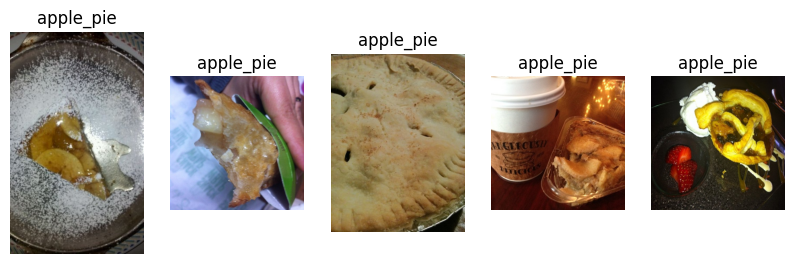

In [3]:
# Display sample images from a random category
categories = [folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))]
print(f'Number of categories: {len(categories)}')

def plot_sample_images(category):
    category_path = os.path.join(data_dir, category)
    images = os.listdir(category_path)
    sample_images = images[:5]
    
    plt.figure(figsize=(10, 10))
    for i, img_name in enumerate(sample_images):
        img = Image.open(os.path.join(category_path, img_name))
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.title(category)
        plt.axis('off')
    plt.show()

# Display sample images from the first category
plot_sample_images(categories[0])


# Data Preparation
## Data Augmentation and Preprocessing

In [6]:
# Define image size and batch size
img_height, img_width = 224, 224
batch_size = 16  # Reduced batch size

# Use ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% of the data for validation
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 80800 images belonging to 101 classes.
Found 20200 images belonging to 101 classes.


# Train the Model

In [7]:
def create_custom_cnn(input_shape, num_classes):
    model = Sequential()

    # First convolutional block
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))

    # Second convolutional block
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Third convolutional block
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))  # Reduced size
    model.add(Dropout(0.5))  # Dropout for regularization
    model.add(Dense(num_classes, activation='softmax'))  # Output layer

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Create the model
input_shape = (img_height, img_width, 3)
num_classes = len(categories)
custom_cnn = create_custom_cnn(input_shape, num_classes)

# Model summary
custom_cnn.summary()

# Optional: Visualize the model architecture
plot_model(custom_cnn, to_file='custom_cnn_model.png', show_shapes=True, show_layer_names=True)


ResourceExhaustedError: {{function_node __wrapped__StatelessRandomUniformV2_device_/job:localhost/replica:0/task:0/device:CPU:0}} OOM when allocating tensor with shape[86528,256] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu [Op:StatelessRandomUniformV2] name: 

# Evaluate the Model